将数据从mongodb数据写入到一个csv文件中

In [73]:
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
client = client['xiaozhu']                                  # 连接到一个数据库client
house_info = client['house_info']                         # 创建一个集合house_infos，包含租房信息

In [74]:
from pprint import pprint

# 显示列名
house_info.find_one().keys()

dict_keys(['rate', 'layout', 'sex_landlord', 'rent_cost_day', 'area', 'link', 'title', 'name_landlord', 'city', 'address', 'beds', '_id', 'sumpeople'])

In [75]:
# 将数据写入csv文件。看来对mongodb数据库不怎么熟悉啊

import csv

headers = ['address', 'title', 'area', 'sex_landlord', 'rent_cost_day', 'name_landlord', 'layout', 'city', 'sumpeople', 'beds', 'link', 'rate']
with open("xiaozhu.csv", 'w', newline='') as f:
    f_csv = csv.writer(f)
    f_csv.writerow(headers)
    for i in house_info.find():
        i["title"] = i["title"].replace("\u2665", "").replace("\u2022", "").replace("\xb2", "").replace("\u20e3", "")
        i["title"] = i["title"].replace("\ufe0f", "").replace("\u2b50", "").replace("\xa0", "").replace("\xab", "")
        i["title"] = i["title"].replace("\xbb", "").replace("\u4616", "").replace("\u265b", "").replace("\u1770", "")
        i["title"] = i["title"].replace("\u0fc1", "").replace("\u2727", "").replace("\u2764","").replace("\u2714", "")
        i["title"] = i["title"].replace("\u2795", "").replace("\u2777", "").replace("\u2778", "").replace("\u21b9", "")
        i["address"] = i["address"].replace("\u202a", "")
        data = [i['address'], i['title'], i['area'], i['sex_landlord'], i['rent_cost_day'], i['name_landlord'], i['layout'], i['city'], i['sumpeople'], i['beds'], i['link'], i['rate']]
        f_csv.writerow(data)

# 导入库

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
from matplotlib import pyplot as plt
from scipy import stats
from pprint import pprint
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

# 导入数据

In [2]:
data = pd.read_csv("xiaozhu.csv", encoding="gbk")

## 数据摘要

数据集形状

In [3]:
data.shape

(2399, 12)

数据集前几行

In [4]:
data.head(3)

,address,title,area,sex_landlord,rent_cost_day,name_landlord,layout,city,sumpeople,beds,link,rate
0,北京市朝阳区惠新东街甲3号楼,【商旅首选】近鸟巢外经贸惠新西街北口阳光主卧,20平米,Male,258,javonjiang,2室2厅1卫1厨1阳台,北京,宜住2人,共1张,http://bj.xiaozhu.com/fangzi/16007105403.html,5分
1,北京市海淀区莲宝路,直达北京站近地铁1号线301医院天安门北海,112平米,Female,498,高兴的home,2室1厅1卫1厨2阳台,北京,宜住7人,共4张,http://bj.xiaozhu.com/fangzi/4915383714.html,5分
2,北京市朝阳区世纪东方嘉园北区,【Piu Piu】北欧性冷淡风三居室 邻地铁,102平米,Female,698,雪snow_,3室1厅1卫1厨1阳台,北京,宜住6人,共3张,http://bj.xiaozhu.com/fangzi/17400412103.html,5分


查看数据的结构、分析缺失值

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2399 entries, 0 to 2398
Data columns (total 12 columns):
address          2399 non-null object
title            2399 non-null object
area             2399 non-null object
sex_landlord     2399 non-null object
rent_cost_day    2399 non-null int64
name_landlord    2399 non-null object
layout           2399 non-null object
city             2399 non-null object
sumpeople        2399 non-null object
beds             2399 non-null object
link             2399 non-null object
rate             1933 non-null object
dtypes: int64(1), object(11)
memory usage: 225.0+ KB


# 特征工程

## 创建新的特征列,进行数据清洗

In [6]:
data["area"] = data["area"].apply(lambda x: int(x.replace("平米", "")))

In [7]:
data["district"] = data["address"].apply(lambda x: x.split("市")[1].split("区")[0]+"区")

In [8]:
data["sex_landlord"] = data["sex_landlord"].apply(lambda x: x.strip())
data["name_landlord"] = data["name_landlord"].apply(lambda x: x.strip())

In [9]:
data["layout"] = data["layout"].apply(lambda x: x.strip().replace("室", " ")\
                                      .replace("厅", " ").replace("卫", " ").replace("厨", " ").replace("阳台", " "))
data["bedrooms"] = data["layout"].apply(lambda x: int(x.split(" ")[0]))
data["livingrooms"] = data["layout"].apply(lambda x: int(x.split(" ")[1]))
data["wcrooms"] = data["layout"].apply(lambda x: int(x.split(" ")[2]))
data["kitchrooms"] = data["layout"].apply(lambda x: int(x.split(" ")[3]))
data["balcony"] = data["layout"].apply(lambda x: int(x.split(" ")[4]))

data["rooms"] = data["bedrooms"] + data["livingrooms"] + data["wcrooms"] + data["kitchrooms"] + data["balcony"]
data = data.drop(["bedrooms", "livingrooms", "wcrooms", "kitchrooms", "balcony", "layout"], axis=1)

In [10]:
data["sumpeople"] = data["sumpeople"].apply(lambda x: int(x.replace("宜住", "").replace("人", "").replace("大于", "")))

In [11]:
data["beds"] = data["beds"].apply(lambda x: int(x.replace("共", "").replace("张", "")))

In [12]:
data["rate"] = data["rate"].apply(lambda x: str(x).replace("分", ""))
data.loc[data["rate"] == "nan", "rate"] = np.nan
data["rate"] = data["rate"].apply(lambda x: np.float(x))

## 缺失值分析

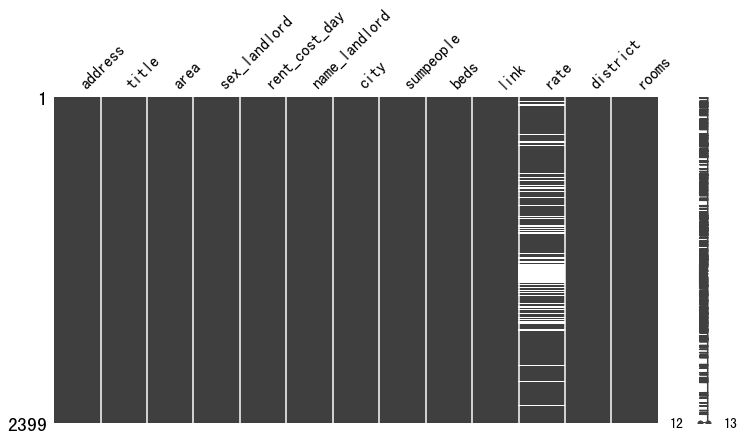

In [13]:
msno.matrix(data, figsize=(12, 6))
plt.show()

从上图可以看出变量rate有缺失值
<br>

In [14]:
bj_sum = sum(data["city"] == "北京")
sh_sum = sum(data["city"] == "上海")
gz_sum = sum(data["city"] == "广州")
sz_sum = sum(data["city"] == "深圳")
cs_sum = sum(data["city"] == "长沙")
wh_sum = sum(data["city"] == "武汉")
cd_sum = sum(data["city"] == "成都")
cq_sum = sum(data["city"] == "重庆")

df = {
    "北京": bj_sum, "上海": sh_sum, "广州": gz_sum, "深圳": sz_sum,
     "长沙": cs_sum, "武汉": wh_sum, "成都": cd_sum, "重庆": cq_sum,
}
pprint(df)


{'上海': 300,
 '北京': 300,
 '广州': 299,
 '成都': 300,
 '武汉': 300,
 '深圳': 300,
 '重庆': 300,
 '长沙': 300}


从上面可知我们分别从7个城市爬取了300组数据, 从广州获取了299组数据。大小几乎一致

In [15]:
bj_missing = sum(np.isnan(data.loc[data["city"] == "北京", "rate"]))
sh_missing = sum(np.isnan(data.loc[data["city"] == "上海", "rate"]))
gz_missing = sum(np.isnan(data.loc[data["city"] == "广州", "rate"]))
sz_missing = sum(np.isnan(data.loc[data["city"] == "深圳", "rate"]))
cs_missing = sum(np.isnan(data.loc[data["city"] == "长沙", "rate"]))
wh_missing = sum(np.isnan(data.loc[data["city"] == "武汉", "rate"]))
cd_missing = sum(np.isnan(data.loc[data["city"] == "成都", "rate"]))
cq_missing = sum(np.isnan(data.loc[data["city"] == "重庆", "rate"]))

查看各个城市的短租房评分rate缺失值的条形图


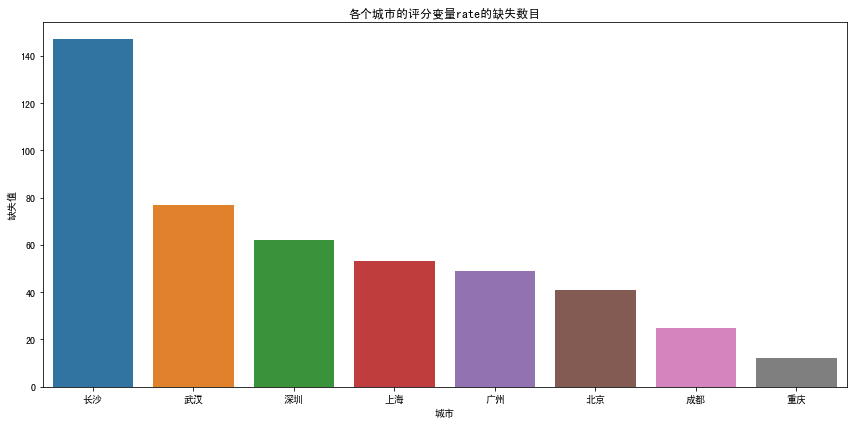

In [16]:
df = pd.DataFrame({
        "city": ["北京", "上海", "广州", "深圳", "长沙", "武汉","成都", "重庆"],
        "missing": [bj_missing, sh_missing, gz_missing, sz_missing, cs_missing, wh_missing, cd_missing, cq_missing],
    })
df = df.sort_values(by="missing", ascending=False)
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
sns.barplot(data=df, x="city", y="missing", ax=ax)
ax.set(xlabel="城市", ylabel="缺失值", title="各个城市的评分变量rate的缺失数目")
plt.tight_layout()

从上图中除了长沙市的评分变量rate缺失数量过多, 达到爬取的长沙市短租房数据值的一半。说明在长沙租房的短期租客不怎么喜爱评价。<br>
其他城市的评分变量rate缺失数目都小于30%, 其中最少的是成都和重庆市, 只有25和12个缺失值。说明短租房在川渝两地比较受欢迎<br>


In [17]:
drop_variable = ["address", "name_landlord", "rate"]
# 去掉不重要的信息后再分析
data = data.drop(drop_variable, axis=1)

In [18]:
data.head(10)

,title,area,sex_landlord,rent_cost_day,city,sumpeople,beds,link,district,rooms
0,【商旅首选】近鸟巢外经贸惠新西街北口阳光主卧,20,Male,258,北京,2,1,http://bj.xiaozhu.com/fangzi/16007105403.html,朝阳区,7
1,直达北京站近地铁1号线301医院天安门北海,112,Female,498,北京,7,4,http://bj.xiaozhu.com/fangzi/4915383714.html,海淀区,7
2,【Piu Piu】北欧性冷淡风三居室 邻地铁,102,Female,698,北京,6,3,http://bj.xiaozhu.com/fangzi/17400412103.html,朝阳区,7
3,朝阳大悦城青年路欧式田园阳光次卧,15,Female,218,北京,1,1,http://bj.xiaozhu.com/fangzi/17462338503.html,朝阳区,8
4,近国贸7号线百子湾站大空间一居-恋爱的马卡龙,62,Female,498,北京,1,3,http://bj.xiaozhu.com/fangzi/19147564303.html,朝阳区,4
5,7号线（温馨小窝）百子湾邻国贸CBDLOFT,62,Female,448,北京,2,1,http://bj.xiaozhu.com/fangzi/19487749803.html,朝阳区,5
6,【探索者之家】国贸CBD女生床位独卫 星宿1,5,Male,130,北京,1,2,http://bj.xiaozhu.com/fangzi/6145828315.html,朝阳区,8
7,四惠东1号线青年路6号线 文艺自然清新二居租,86,Female,486,北京,4,2,http://bj.xiaozhu.com/fangzi/2913942963.html,朝阳区,6
8,万科地产城市之光,83,Male,418,北京,4,2,http://bj.xiaozhu.com/fangzi/17634258003.html,通州区,6
9,后海的家—海景房（观海、吹海风的最佳场所）,55,Male,1200,北京,3,2,http://bj.xiaozhu.com/fangzi/6214168916.html,西城区,5


## 异常值分析

画出目标变量日租金的箱线图, 以及目标变量关于分类变量的箱线图

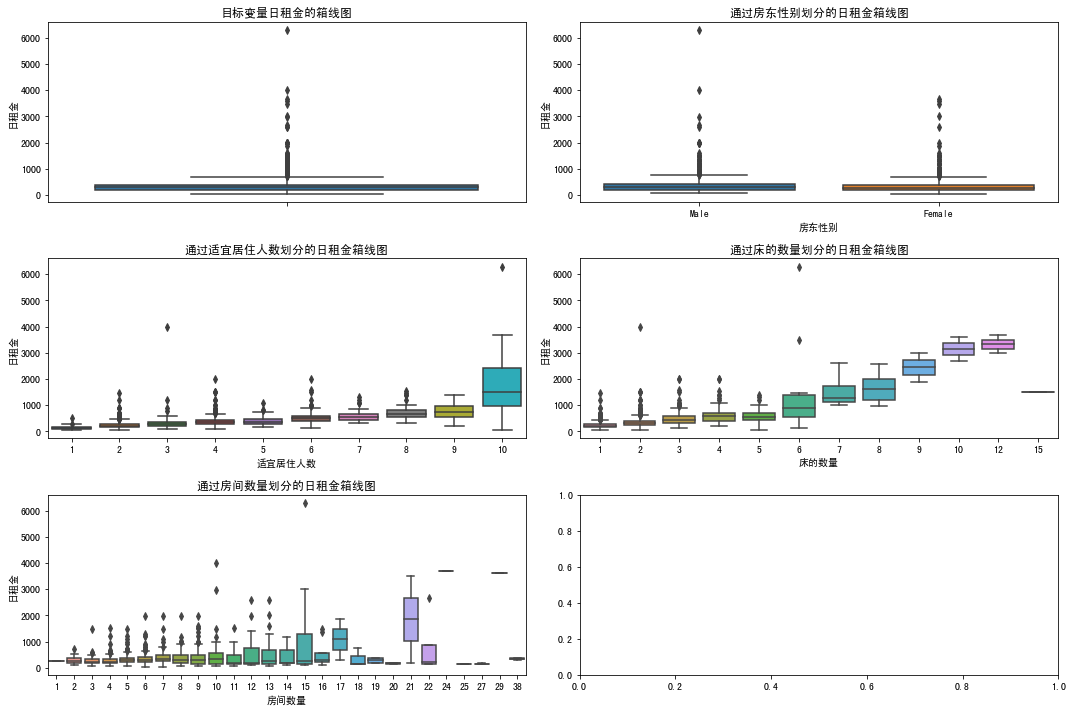

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(15, 10)

sns.boxplot(y="rent_cost_day", data=data, orient="v", ax=axes[0][0])
axes[0][0].set(ylabel="日租金", title="目标变量日租金的箱线图")

sns.boxplot(x="sex_landlord", y="rent_cost_day", data=data,orient="v",ax=axes[0][1])
axes[0][1].set(ylabel="日租金", xlabel="房东性别", title="通过房东性别划分的日租金箱线图")

sns.boxplot(x="sumpeople", y="rent_cost_day", data=data,orient="v",ax=axes[1][0])
axes[1][0].set(ylabel="日租金", xlabel="适宜居住人数", title="通过适宜居住人数划分的日租金箱线图")

sns.boxplot(x="beds", y="rent_cost_day", data=data,orient="v",ax=axes[1][1])
axes[1][1].set(ylabel="日租金", xlabel="床的数量", title="通过床的数量划分的日租金箱线图")

sns.boxplot(x="rooms", y="rent_cost_day", data=data,orient="v",ax=axes[2][0])
axes[2][0].set(ylabel="日租金", xlabel="房间数量", title="通过房间数量划分的日租金箱线图")

plt.tight_layout()

In [20]:
# 保存每行的目标变量rent_cost_day列不存在异常值的数据行
clean_data = data[np.abs(data["rent_cost_day"]-data["rent_cost_day"].mean()) <= (3*data["rent_cost_day"].std())]

print("除去异常值之前的数据集形状: ", data.shape)
print("出去异常值之后的数据集形状: ", clean_data.shape)

除去异常值之前的数据集形状:  (2399, 10)
出去异常值之后的数据集形状:  (2361, 10)


## 相关性分析

研究<strong>目标变量</strong>如何被<strong>数值型变量</strong>影响</strong><br>
画出数值型变量的相关系数图

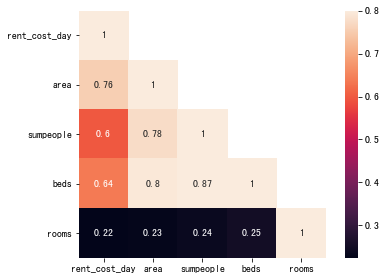

In [21]:
numericalVariable = ["rent_cost_day", "area", "sumpeople", "beds", "rooms"]
corrMat = data[numericalVariable].corr()
Array = np.array(corrMat)                            # 将系数矩阵转化为二维数组
Array[np.tril_indices_from(Array)] = False           # 去除系数矩阵的上半部分
fig, ax = plt.subplots()
sns.heatmap(corrMat, mask=Array, vmax=.8, square=True, annot=True)
plt.tight_layout()

可以看出:<br>
面积与日租金相关系数最大, 有0.78。<br>
适宜居住人数与日租金的相关系数为0.6。床的数目与日租金的相关系数有0.64。<br>
房间的数量与日租金的相关系数为0.22,相关性最弱。<br>
其实sumpeople、beds、rooms这三个变量应该属于类别型变量, 我们将其强制转化为category类型。

In [22]:
for var in ["sumpeople", "beds", "rooms", "sex_landlord"]:
    data[var] = data[var].astype("category")

数值型变量与目标变量的关系图<br>
从下图可以看到房屋面积与日租金明显有正相关关系, 即一般来说, 房子面积越大, 租金越高。

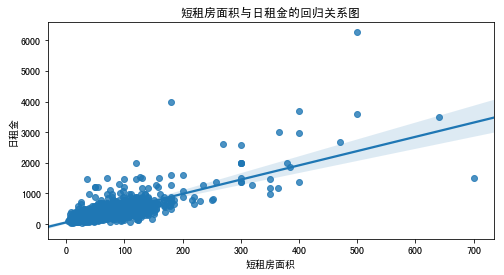

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(8,4)
sns.regplot(x="area", y="rent_cost_day", data=data, ax=ax)
ax.set(xlabel="短租房面积", ylabel="日租金", title="短租房面积与日租金的回归关系图")

## 数值型变量详细分析

In [24]:
data.describe()

,area,rent_cost_day
count,2399.000000,2399.000000
mean,62.299291,346.566486
std,50.312017,309.596892
min,3.000000,41.000000
25%,32.000000,189.000000
50%,55.000000,288.000000
75%,80.000000,398.000000
max,700.000000,6288.000000


 通过上面的表格
1. 房子的面积最大有700平米，最小为3平米, 这可能是个异常值, 平均大小为62平米。75%的房屋面积小于80个平米。有50%的房屋面积处于32~80平米<br>
2. 日租金平均为346元/天, 最便宜的租金为41元/天。最贵的租金为6288元/天，这个可能是异常值。有50%的日租金处于189~398元/天。
<br>
<br>

对日租金进行详细分析

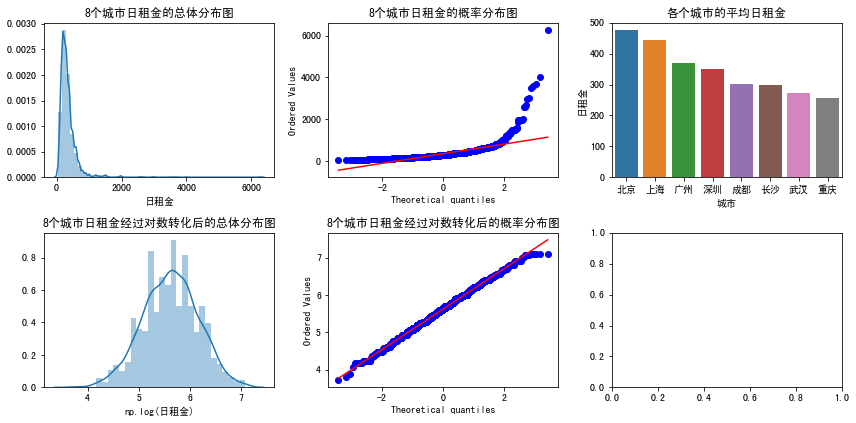

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(12, 6)
sns.distplot(data["rent_cost_day"], ax=axes[0][0])
axes[0][0].set(xlabel="日租金", title="8个城市日租金的总体分布图")

stats.probplot(data["rent_cost_day"], dist="norm", fit=True, plot=axes[0][1])
axes[0][1].set(title="8个城市日租金的概率分布图")

df = pd.DataFrame(data.groupby(["city"])["rent_cost_day"].mean()).reset_index()
df.sort_values(by="rent_cost_day", ascending=False)
sortOrder = ["北京", "上海", "广州", "深圳", "成都", "长沙", "武汉", "重庆"]
sns.barplot(data=df, x="city", y="rent_cost_day", order=sortOrder, ax=axes[0][2])
axes[0][2].set(xlabel="城市", ylabel="日租金", title="各个城市的平均日租金")


# 将出去异常值的数据集的目标变量日租金取自然对数
sns.distplot(np.log(clean_data["rent_cost_day"]), ax=axes[1][0])
axes[1][0].set(xlabel="np.log(日租金)", title="8个城市日租金经过对数转化后的总体分布图")

stats.probplot(np.log(clean_data["rent_cost_day"]), dist="norm", fit=True, plot=axes[1][1])
axes[1][1].set(title="8个城市日租金经过对数转化后的概率分布图")

plt.tight_layout()

从第一个图和第二个图可以看出日租金明显右偏。我们对这个变量进行对数转化。<br>
经过对数转化后可以看到比较符合正态分布。<br>
从第三个图形可知：<br>
平均日租金最高的是北京,大概为480元, 其次是上海,大概为450元。重庆的平均日租金最低,大概为260元。<br>
这与各地的消费水平和经济发达程度以及物价大体保持一致。长沙、重庆、成都、武汉等消费型城市的日租金明显低于北上广深一线城市。
<br>
<br>

绘制各个城市的各个区县短租房日租金的散点图, 并用折线连接

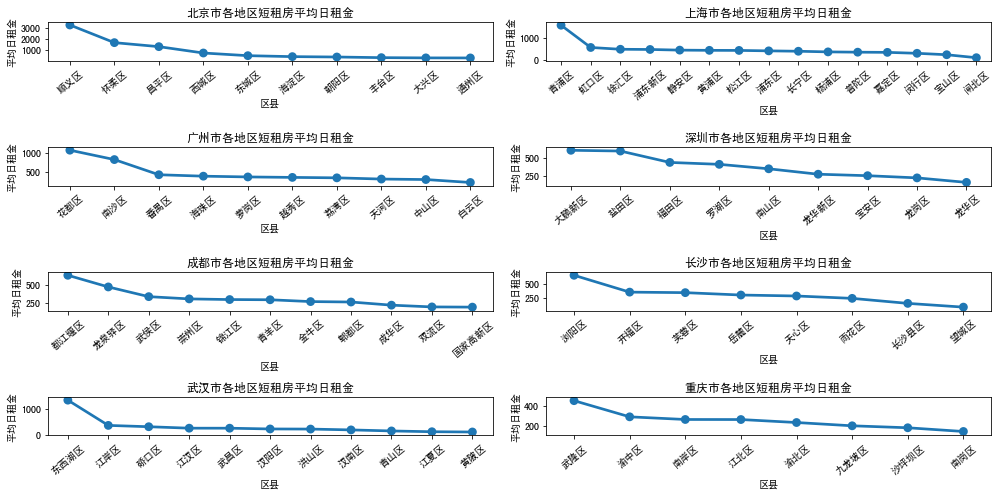

In [26]:
cities = ["北京", "上海", "广州", "深圳", "成都", "长沙", "武汉", "重庆"]
rows = [0, 0, 1, 1, 2, 2, 3, 3]
cols = [0, 1, 0, 1, 0, 1, 0, 1]

fig, axes = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(14, 7)


for (city, i, j) in zip(cities, rows, cols):
    df = pd.DataFrame(data.groupby(["city", "district"])["rent_cost_day"].mean()).reset_index()
    df1 = df[df["city"] == city].sort_values(by="rent_cost_day", ascending=False)
    g = sns.pointplot(x="district", y="rent_cost_day", join=True, data=df1, ax=axes[i][j])
    axes[i][j].set(xlabel="区县", ylabel="平均日租金", title="{}市各地区短租房平均日租金".format(city))
    g.set_xticklabels(labels=df1["district"], rotation=40)
    plt.tight_layout()
    

对房子面积进行分析, 容易看到经过对数转化后的数据更符合正态分布的总体假设<br>
通过对各个城市的短期出租房子面积的描述可以看出<br>
成都、长沙短期出租房子的面积平均大小居于前两位, 而深圳由于地方比较小, 所以出租的房子面积大小居于最后。

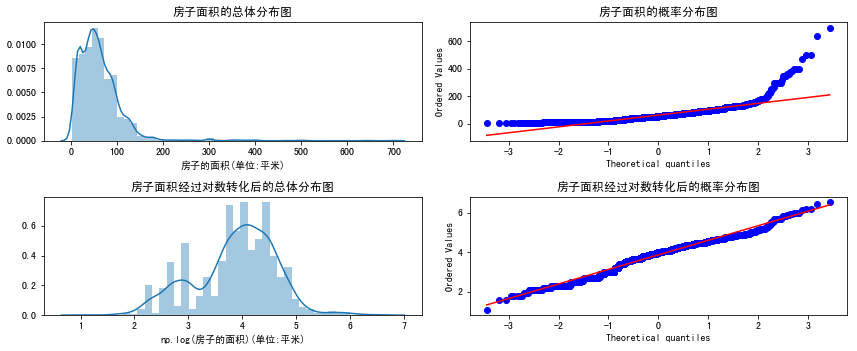

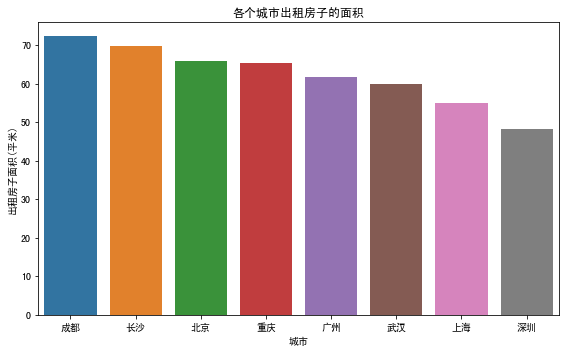

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 5)

sns.distplot(data["area"], ax=axes[0][0])
axes[0][0].set(xlabel="房子的面积(单位:平米)", title="房子面积的总体分布图")
stats.probplot(data["area"], dist="norm", fit=True, plot=axes[0][1])
axes[0][1].set(title="房子面积的概率分布图")

sns.distplot(np.log(data["area"]), ax=axes[1][0])
axes[1][0].set(xlabel="np.log(房子的面积)(单位:平米)", title="房子面积经过对数转化后的总体分布图")
stats.probplot(np.log(data["area"]), dist="norm", fit=True, plot=axes[1][1])
axes[1][1].set(title="房子面积经过对数转化后的概率分布图")
plt.tight_layout()

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

df = pd.DataFrame(data.groupby(["city"])["area"].mean()).reset_index()
df.sort_values(by="area", ascending=False)
sortOrder = ["成都", "长沙", "北京", "重庆", "广州", "武汉", "上海", "深圳"]
sns.barplot(data=df, x="city", y="area", order=sortOrder, ax=ax)
ax.set(xlabel="城市", ylabel="出租房子面积(平米)", title="各个城市出租房子的面积")
plt.tight_layout()

## 类别型变量详细分析:
1. 八座城市的房东性别比例

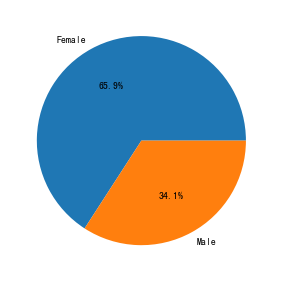

In [28]:
df = pd.DataFrame(pd.Series(data["sex_landlord"]).value_counts()).reset_index().rename(columns={"index": "sex", "sex_landlord": "count"})
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(4, 4)
plt.pie(df["count"].values, labels=df["sex"].values, autopct='%1.1f%%')
plt.tight_layout()

从上图可以看出女性房东的占比65.9%明显多于男性房东比34.1%。说明租房这种事还是女性来负责比较合适，女性比较细心。<br>
<br>

2. 观察各个城市的各个区的发布短租房信息的数目

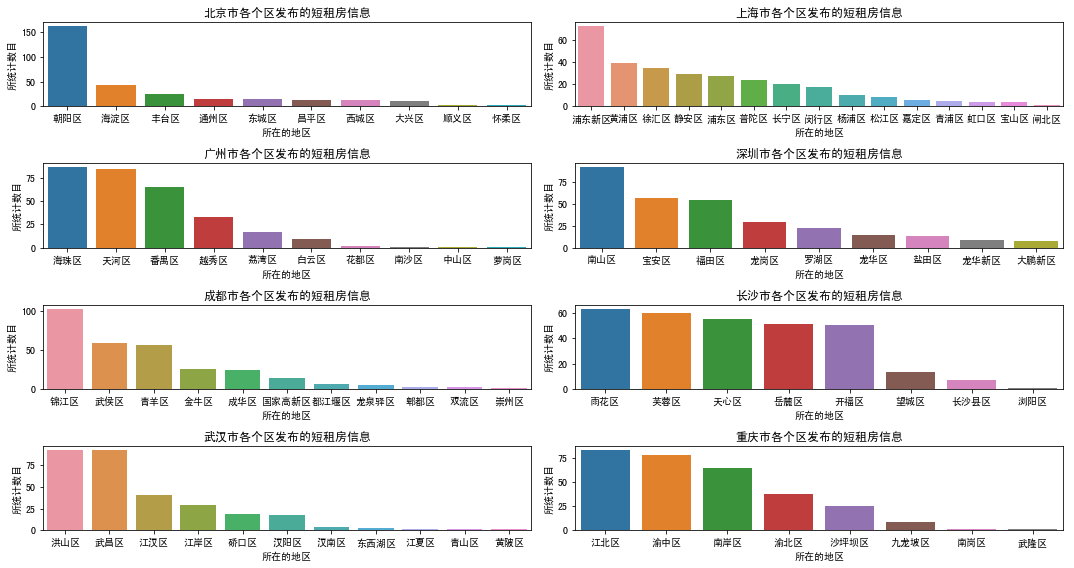

In [29]:
cities = ["北京", "上海", "广州", "深圳", "成都", "长沙", "武汉", "重庆"]
rows = [0, 0, 1, 1, 2, 2, 3, 3]
cols = [0, 1, 0, 1, 0, 1, 0, 1]


fig, axes = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(15, 8)
for (city,i,j)in zip(cities, rows, cols):
    df = data[data["city"] == city]
    df = pd.DataFrame(pd.Series(df["district"]).value_counts()).reset_index().rename(columns={"index": "district", "district": "num"})
    df.sort_values(by="num", ascending=False)               # 按降序排列
    sns.barplot(x=df["district"], y=df["num"], ax=axes[i][j], orient="v")
    axes[i][j].set(xlabel="所在的地区", ylabel="所统计数目", title="{}市各个区发布的短租房信息".format(city))
    plt.tight_layout()


从上述图形可知：<br>
1, 北京发布短租房信息最多的地区是朝阳区，所占比例超过50%。朝阳区以经济娱乐为主。其他地区发布信息较少。<br>
2, 上海发布短租房信息最多的地区是浦东新区,所占比例约为26%。浦东新区作为全国经济改革开放的前沿地带,经济发达,主要支柱为商业金融。<br>
3, 广州海珠区和天河区的比例大致相似,居第一二位。深圳发布信息最多的地区是南山区,将近三分之一的比例。其次是宝安区和福田区。<br>
4, 长沙发布短租房信息的地区分布比较均匀,雨花区、芙蓉区等5个区的比例大致为16%~20%。望城、长沙县、浏阳发布的信息比较少。这跟它们远离市中心有一定的关系<br>
<strong>其他城市可以依次分析。可以看出发布信息较多的地区一般是经济比较繁荣、娱乐气息浓厚的地区、这些地区物质文化比较发达。消费一般居于所占城市的前列</strong><br>
<br>
<br>